# Intro & Import packages

  Title: Simple 2D Beam Bridge Model in OpenSees with Moving Loads

  Author:  Mohammad Talebi-Kalaleh
           Research Assistant at University of Alberta, Structural Engineering
  Email:   talebika@ualberta.ca

  Description:
    This script demonstrates how to create a 2D beam bridge model in OpenSeesPy
    and apply moving loads (e.g., truck axles) via a Path TimeSeries approach:

      1) Build a beam model using elasticBeamColumn elements.

      2) Compute full nodal load time histories based on axle positions.

      3) Assign a Path TimeSeries to each node to represent the time-varying
         loads.

      4) Perform a transient analysis step-by-step, capturing displacement,
         velocity, acceleration, shear, and moment over time.

      5) Generate envelope diagrams for shear and moment.


  Usage:
    - Update input parameters (geometry, material, load definitions) in the
      __main__ section or feed them from an external source.
    - Run the script; results are plotted (midspan response and envelopes).

  Requirements:
    - Python 3.x
    - numpy
    - matplotlib
    - OpenSeesPy



In [12]:
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
import numpy as np
import matplotlib.pyplot as plt

# Update global plot settings

In [13]:
plt.rcParams.update({
    'font.size': 16,
    'lines.linewidth': 2,
    'figure.facecolor': 'white',
    'savefig.facecolor': 'white',
    'axes.facecolor': 'white',   # White background behind the data
    'axes.edgecolor': 'black',   # Black border around axes
    'axes.linewidth': 1.2,       # Thickness of the black border
    'axes.grid': True,
    'grid.color': 'gray',       # Gray grid lines
    'grid.linestyle': '--',     # Dashed grid lines
    'grid.linewidth': 0.6,      # Thinner grid lines
})

# Utility Functions

In [14]:
def build_bridge_model(bridge_length,
                       support_positions,
                       E,
                       rho,
                       A,
                       I,
                       damping_ratio,
                       mesh_size=0.5):
    """
    Constructs a 2D beam bridge (3 DOFs per node) in OpenSees using
    elasticBeamColumn elements. Assigns boundary conditions, mass, and
    Rayleigh damping based on the first two modes.

    Parameters
    ----------
    bridge_length : float
        Total bridge length in meters.
    support_positions : list of float
        Positions of interior supports along the bridge (m from left end).
    E : float
        Elastic (Young's) Modulus in Pa.
    rho : float
        Material density (kg/m^3).
    A : list[float] or float
        Cross-sectional area(s) [m^2]. If uniform, pass one value; for multiple
        spans with different sections, pass one A per span.
    I : list[float] or float
        Second moment(s) of area [m^4]. Same indexing as A.
    damping_ratio : float
        Desired damping ratio for the first two modes (Rayleigh).
    mesh_size : float
        Element length for discretization (m).

    Returns
    -------
    dict
        A dictionary with keys:
          - 'all_node_tags': list of int (node tags)
          - 'all_node_positions': list of float (x-coords)
          - 'span_element_tags': list of lists of element tags
          - 'support_node_tags': node tags of supports
          - 'omega': [omega1, omega2]
    """
    # Clear any existing OpenSees model
    ops.wipe()

    # Define a 2D model with 3 dofs/node
    ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)

    # Ensure 0 and bridge_length are included in supports
    all_support_positions = sorted(set([0.0] + support_positions + [bridge_length]))

    current_node_tag = 1
    span_node_tags = []
    all_node_positions = []

    # Mesh each span according to mesh_size
    for i in range(len(all_support_positions) - 1):
        span_start = all_support_positions[i]
        span_end   = all_support_positions[i+1]
        span_length = span_end - span_start
        n_seg = int(np.ceil(span_length / mesh_size))
        dx = span_length / n_seg
        this_span_nodes = []

        for j in range(n_seg + 1):
            xcoord = span_start + j * dx
            if i == 0:
                current_node_tag += 1
                ops.node(current_node_tag, xcoord, 0.0)
                all_node_positions.append(xcoord)
            else:
                if j != 0:
                    current_node_tag += 1
                    ops.node(current_node_tag, xcoord, 0.0)
                    all_node_positions.append(xcoord)

            this_span_nodes.append(current_node_tag)
        span_node_tags.append(this_span_nodes)

    all_node_tags = [tag for span_nodes in span_node_tags for tag in span_nodes]
    all_node_tags = list(set(all_node_tags)) # pick unique node names
    number_of_nodes = len(all_node_tags)

    # Assign boundary conditions (hinge at first support, roller at others)
    support_node_tags = []
    for sPosIdx, sPos in enumerate(all_support_positions):
        # find the node in all_node_positions closest to sPos
        idx = np.argmin(np.abs(np.array(all_node_positions) - sPos))
        support_node_tag = all_node_tags[idx]
        support_node_tags.append(support_node_tag)
        if sPosIdx == 0:
            # Hinge
            ops.fix(support_node_tag, 1, 1, 0)
        else:
            # Roller in x-direction
            ops.fix(support_node_tag, 0, 1, 0)

    # Beam transformation
    transf_tag = 1
    ops.geomTransf('Linear', transf_tag)

    # If A or I are single values, replicate them across all spans
    n_spans = len(all_support_positions) - 1
    if len(A) == 1:
        A = A * n_spans
    if len(I) == 1:
        I = I * n_spans

    # Create elements for each span
    current_element_tag = 1
    span_element_tags = []
    for i, span_nodes in enumerate(span_node_tags):
        Ei = E
        Ai = A[i]
        Ii = I[i]

        this_span_elems = []
        for j in range(len(span_nodes) - 1):
            nd_i = span_nodes[j]
            nd_j = span_nodes[j + 1]
            ops.element('elasticBeamColumn',
                        current_element_tag,
                        nd_i,
                        nd_j,
                        Ai,
                        Ei,
                        Ii,
                        transf_tag)
            this_span_elems.append(current_element_tag)
            current_element_tag += 1

        span_element_tags.append(this_span_elems)

    # Assign nodal mass (distribute half to each element end)
    for i, span_nodes in enumerate(span_node_tags):
        linear_mass_i = rho * A[i]  # linear mass (kg/m)
        for j in range(len(span_nodes) - 1):
            nd_i = span_nodes[j]
            nd_j = span_nodes[j + 1]
            xi = ops.nodeCoord(nd_i)[0]
            xj = ops.nodeCoord(nd_j)[0]
            le = xj - xi
            # half of the mass to node i, half to node j
            ops.mass(nd_i, 0.0, ops.nodeMass(nd_i)[1] + 0.5 * linear_mass_i * le, 0.0)
            ops.mass(nd_j, 0.0, ops.nodeMass(nd_j)[1] + 0.5 * linear_mass_i * le, 0.0)

    # Eigen analysis for first 2 modes
    num_modes = 2
    eigenvals = ops.eigen(num_modes)
    omega_list = np.sqrt(eigenvals)
    # Plot mode shapes (optional)
    for i, omega in enumerate(omega_list):
        opsv.plot_mode_shape(i+1)
        plt.title(f'Mode {i+1}, $f_{i+1}$={round(omega/(2*np.pi), 2)} Hz')
        plt.xlim([min(all_support_positions), max(all_support_positions)])
        plt.show()

    # Return dictionary with metadata for future usage
    bridge_dict = {
        'all_node_tags': all_node_tags,
        'all_node_positions': all_node_positions,
        'span_node_tags': span_node_tags,
        'span_element_tags': span_element_tags,
        'all_support_positions': all_support_positions,
        'support_node_tags': support_node_tags,
        'number_of_nodes': number_of_nodes,
        'omega': omega_list,
        'damping_ratio': damping_ratio
    }
    return bridge_dict

def interpolate_position_at_time(t, time_position_table):
    """
    Interpolate the trailing axle position at time 't' using np.interp.
    If t < t_min, returns x_min; if t > t_max, returns x_max.
    """
    # Extract separate arrays for times and positions
    times = np.array([row[0] for row in time_position_table])
    positions = np.array([row[1] for row in time_position_table])

    # Use np.interp for linear interpolation
    x_t = np.interp(t, times, positions)
    return x_t

def get_nodal_forces_for_all_times(time_steps,
                                   trailing_axle_path,
                                   vehicle_config,
                                   node_tags,
                                   node_positions):
    """
    Pre-compute the full time history of vertical load at each node due to
    a vehicle whose trailing axle position is given by 'trailing_axle_path',
    and whose axle loads/distances are given in 'vehicle_config'.

    vehicle_config = {
      'loads': [axle1_load, axle2_load, ...],
      'distances': [0.0, dist2, dist3, ...]
    }

    Parameters:
    -----------
    time_steps        : np.array
                        Array of times (s).
    trailing_axle_path: list of [time, position]
                        The (time, x-position) history of the trailing axle.
    vehicle_config     : dict
                        'loads' -> list of axle load magnitudes (N),
                        'distances' -> list of distances from trailing axle (m).
    node_tags         : list of int
                        Node tags in order along the bridge.
    node_positions    : list of float
                        x-coordinates of the node_tags (same order).

    Returns:
    --------
    node_load_history : dict
                        key=node_tag, value = array of shape (len(time_steps),)
                        containing the downward load for that node.
    """

    axle_loads = vehicle_config['loads']
    axle_distances = vehicle_config['distances']
    n_axles = len(axle_loads)  # number of axles

    node_load_history = {nd: np.zeros(len(time_steps)) for nd in node_tags}

    for it, t in enumerate(time_steps):
        # Trailing axle position by interpolation
        trailing_pos = interpolate_position_at_time(t, trailing_axle_path)

        # For each axle, compute x-position
        for ax_idx in range(n_axles):
            x_axle = trailing_pos + axle_distances[ax_idx]
            load_val = axle_loads[ax_idx]

            # Skip if off the bridge
            if x_axle < min(node_positions) or x_axle > max(node_positions):
                continue

            # Find segment to do linear interpolation
            for iSeg in range(len(node_positions) - 1):
                x_i = node_positions[iSeg]
                x_j = node_positions[iSeg + 1]
                nd_i = node_tags[iSeg]
                nd_j = node_tags[iSeg + 1]

                if x_i <= x_axle <= x_j:
                    seg_length = x_j - x_i
                    if seg_length < 1e-12:
                        node_load_history[nd_i][it] += load_val
                    else:
                        r = (x_axle - x_i)/seg_length
                        node_load_history[nd_i][it] += load_val*(1.0 - r)
                        node_load_history[nd_j][it] += load_val*r
                    break

    return node_load_history

def run_dynamic_analysis_with_path_ts(bridge_dict,
                                      trailing_axle_path,
                                      vehicle_config,
                                      dt):
    """
    Constructs Path TimeSeries for each node, capturing the node's
    time-varying load. Then performs a transient analysis step-by-step
    to collect nodal/element responses at each time step.

    Parameters
    ----------
    bridge_dict : dict
        Output of build_bridge_model(...).
    trailing_axle_path : list of [time, position]
        Time-position history for the trailing axle.
    vehicle_config : dict
        'loads': [...], 'distances': [...]
    dt : float
        Time step (s).

    Returns
    -------
    results : dict
        Contains time array, midspan disp/vel/acc, shear/moment over time,
        and envelope values.
    """

    node_tags       = bridge_dict['all_node_tags']
    node_positions  = bridge_dict['all_node_positions']
    span_element_tags = bridge_dict['span_element_tags']
    all_support_positions = bridge_dict['all_support_positions']
    omega1, omega2 = bridge_dict['omega'][:2]
    damping_ratio = bridge_dict['damping_ratio']

    # Determine overall startTime and endTime from trailing_axle_path
    trailing_axle_path = sorted(trailing_axle_path, key=lambda row: row[0])
    start_time = trailing_axle_path[0][0]
    end_time   = trailing_axle_path[-1][0]
    total_time = end_time - start_time

    nSteps = int(np.ceil(total_time/dt)) + 1 if total_time > 1e-12 else 2
    time_steps = np.linspace(start_time, end_time, nSteps)

    # Build nodal load history
    node_load_history = get_nodal_forces_for_all_times(
        time_steps, trailing_axle_path, vehicle_config,
        node_tags, node_positions
    )

    # Create Path TimeSeries & Patterns
    for nd in node_tags:
        ts_tag = 1000 + nd
        # We can use the entire time_steps array
        # For the load values, we supply node_load_history[nd].
        # We'll ensure after the last time, we hold the last load => -useLast
        ops.timeSeries('Path', ts_tag,
                       '-time', *time_steps,
                       '-values', *node_load_history[nd],
                       '-factor', 1.0,
                       '-useLast',    # hold last value after final time
                       '-prependZero' # ensure starts at 0 at time=0
                       )

        pat_tag = 2000 + nd
        ops.pattern('Plain', pat_tag, ts_tag)
        # y-dof is 2 in 2D => (Fx, Fy, Mz) => (0, -1, 0) for scale
        ops.load(nd, 0.0, -1.0, 0.0)

    # Rayleigh damping
    alphaM    = damping_ratio * (2.*omega1*omega2)/(omega1+omega2)
    betaKcomm = 2.*damping_ratio/(omega1+omega2)
    ops.rayleigh(alphaM, 0., 0., betaKcomm)

    # Analysis configuration
    start_time = time_steps[0]
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.algorithm('Linear')
    ops.integrator('Newmark', 0.5, 0.25)
    ops.analysis('Transient')
    ops.setTime(time_steps[0])

    # Identify first midspan node (or other node) for response tracking
    midspan_x = 0.5*(all_support_positions[0] + all_support_positions[1])
    idx_mid = np.argmin(np.abs(np.array(node_positions) - midspan_x))
    mid_node_tag = node_tags[idx_mid]

    # Lists to store time, disp, vel, acc
    time_list = []
    disp_list = []
    vel_list  = []
    acc_list  = []

    # Track shear & moment time histories
    shear_records  = []
    moment_records = []
    all_element_tags = [e for span_elems in span_element_tags for e in span_elems]
    # Step-by-step analysis
    for iStep in range(nSteps):
        # The current step time
        current_time = start_time + iStep*dt
        # We let OpenSees do the time integration of dt
        # but we might check if there's a tiny rounding
        ops.setTime(current_time)

        ok = ops.analyze(1, dt)
        if ok != 0:
            print(f"Analysis failed at step {iStep} (time ~ {ops.getTime():.4f}).")
            break

        # Record time & midspan
        tNow = ops.getTime()
        time_list.append(tNow)
        disp_list.append(ops.nodeDisp(mid_node_tag, 2))
        vel_list.append(ops.nodeVel(mid_node_tag, 2))
        acc_list.append(ops.nodeAccel(mid_node_tag, 2))

        # Shear & moment in each element (i-end)
        # eleForce => [Fx_i, Fz_i, My_i, Fx_j, Fz_j, My_j]
        shear_this = []
        moment_this= []
        for ele in all_element_tags:
            f = ops.eleForce(ele)
            shear_i  = f[1]
            moment_i = f[2]
            shear_this.append(shear_i)
            moment_this.append(moment_i)
        shear_records.append(shear_this)
        moment_records.append(moment_this)

    # Convert to arrays
    time_array = np.array(time_list)
    disp_array = np.array(disp_list)
    vel_array  = np.array(vel_list)
    acc_array  = np.array(acc_list)

    shear_time_history  = np.array(shear_records)
    moment_time_history = np.array(moment_records)

    # Envelope
    shear_envelope_max  = np.max(shear_time_history, axis=0)
    shear_envelope_min  = np.min(shear_time_history, axis=0)
    moment_envelope_max = np.max(moment_time_history, axis=0)
    moment_envelope_min = np.min(moment_time_history, axis=0)

    results = {
        'time': time_array,
        'midspan_disp': disp_array,
        'midspan_vel': vel_array,
        'midspan_acc': acc_array,
        'shear_time_history': shear_time_history,
        'moment_time_history': moment_time_history,
        'shear_envelope_max': shear_envelope_max,
        'shear_envelope_min': shear_envelope_min,
        'moment_envelope_max': moment_envelope_max,
        'moment_envelope_min': moment_envelope_min,
        'element_tags': all_element_tags
    }

    return results

def post_process_and_plot(results_dict):
    """
    Simple post-processing:
      - Plots midspan displacement, velocity, acceleration vs. time.
      - Plots shear & moment envelope diagrams.
    """
    t   = results_dict['time']
    disp= results_dict['midspan_disp']
    vel = results_dict['midspan_vel']
    acc = results_dict['midspan_acc']

    fig, axs = plt.subplots(3,1, figsize=(9,10), sharex=True)
    axs[0].plot(t, 1000*disp, 'b-', label='Midspan Disp (mm)')
    axs[0].legend()
    axs[0].set_xlim([min(t), max(t)])

    axs[1].plot(t, 1000*vel, 'r-', label='Midspan Vel (mm/s)')
    axs[1].legend()
    axs[1].set_xlim([min(t), max(t)])

    axs[2].plot(t, acc/9.81, 'g-', label='Midspan Acc (g)')
    axs[2].legend()
    axs[2].set_xlim([min(t), max(t)])
    axs[2].set_xlabel('Time (s)')

    plt.suptitle('Midspan Response Time Histories')
    plt.tight_layout()
    plt.show()

    # Envelope
    shear_max  = results_dict['shear_envelope_max']
    shear_min  = results_dict['shear_envelope_min']
    moment_max = results_dict['moment_envelope_max']
    moment_min = results_dict['moment_envelope_min']
    elem_tags = results_dict['element_tags']

    x_elem = []
    for et in elem_tags:
        nd_i, nd_j = ops.eleNodes(et)
        xi = ops.nodeCoord(nd_i)[0]
        x_elem.append(xi)
    x_elem = np.array(x_elem)

    sort_idx = np.argsort(x_elem)
    x_sorted = x_elem[sort_idx]
    sh_max_sorted  = shear_max[sort_idx] / 1000.0
    sh_min_sorted  = shear_min[sort_idx] / 1000.0
    m_max_sorted   = moment_max[sort_idx] / 1000.0
    m_min_sorted   = moment_min[sort_idx] / 1000.0

    fig2, ax2 = plt.subplots(2,1, figsize=(9,8), sharex=True)
    ax2[0].plot(x_sorted, sh_max_sorted, 'r-', label='V max')
    ax2[0].plot(x_sorted, sh_min_sorted, 'b-', label='V min')
    ax2[0].set_ylabel('Shear (kN)')
    ax2[0].legend()
    ax2[0].set_xlim([min(x_sorted), max(x_sorted)])

    ax2[1].plot(x_sorted, m_max_sorted, 'r-', label='M max')
    ax2[1].plot(x_sorted, m_min_sorted, 'b-', label='M min')
    ax2[1].set_xlabel('Position (m)')
    ax2[1].set_ylabel('Moment (kN.m)')
    ax2[1].legend()
    ax2[1].set_xlim([min(x_sorted), max(x_sorted)])

    plt.suptitle('Shear & Moment Envelope Diagrams')
    plt.tight_layout()
    plt.show()

# Main (example)
Example usage:
  1) Build a 90 m bridge with interior supports at 30, 60 => three 30 m spans.
  2) Vehicle with 3 axles (20 kN each), 3 m apart.
  3) Trailing axle from x=0 at t=0 to x=bridge_length at t=(bridge_length/speed).
  4) Use np.interp for trailing axle position interpolation.
  5) Step-by-step analysis, plot results.

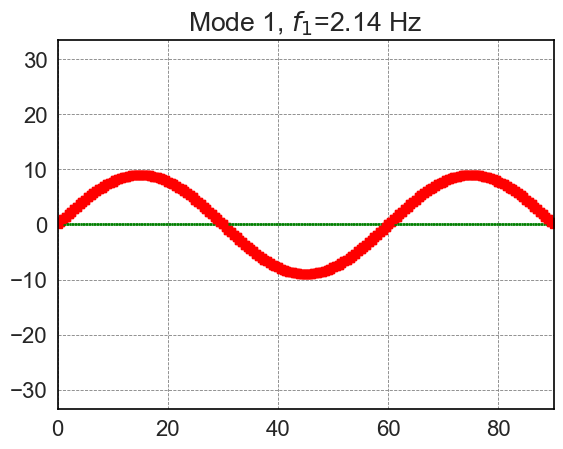

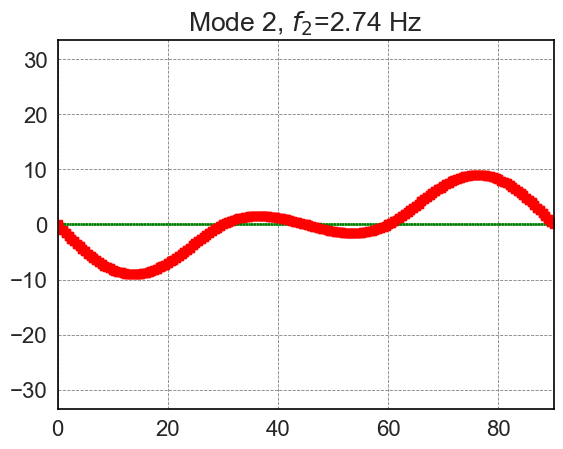

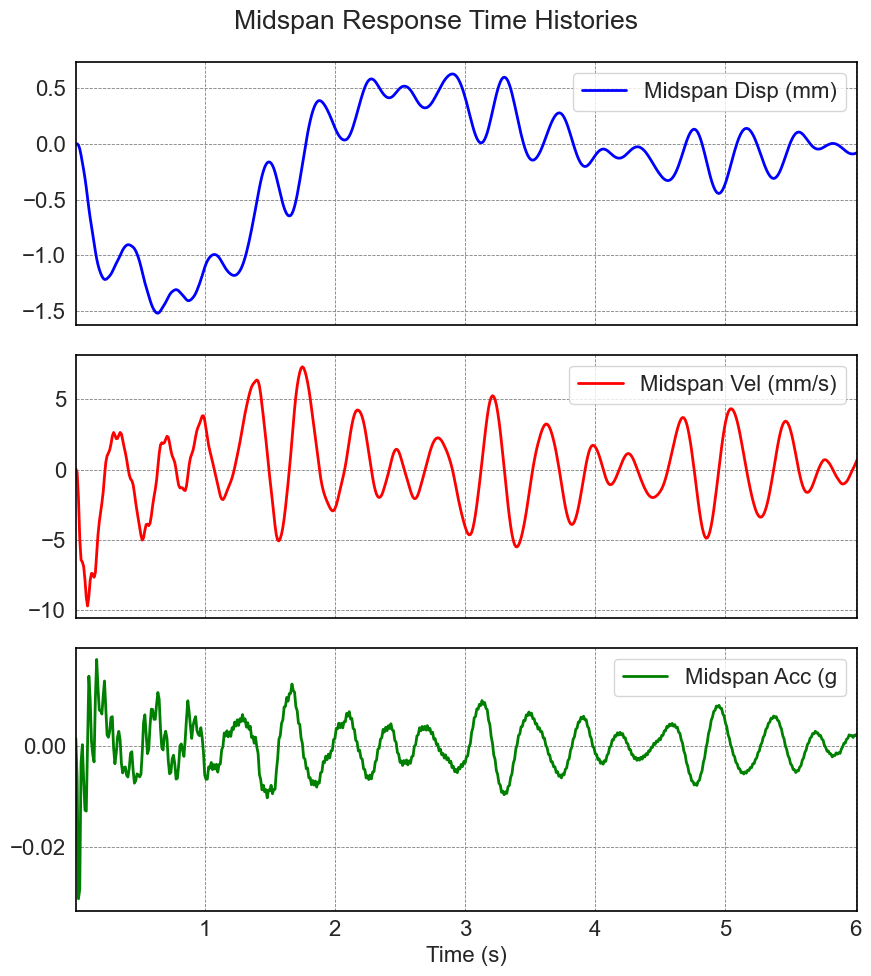

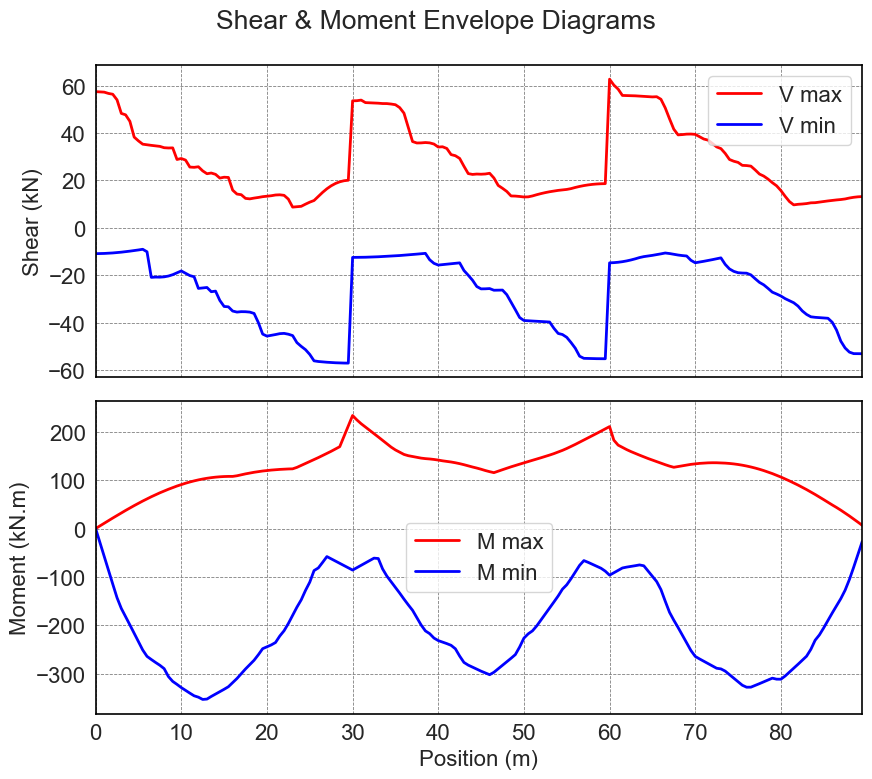

In [15]:
# 1) Bridge geometry & properties
bridge_length     = 90.0
support_positions = [30, 60]  # interior support => three spans of 30m
E   = 20.0e9   # Pa
rho = 2500.0   # kg/m^3
A   = [3 * 1.5]    # cross-sectional area (m^2)
I   = [1/12 * 3 * 1.5**3]    # second moment of area (m^4)
damping_ratio = 0.005
mesh_size = 0.5

# Build the bridge model
bridge_dict = build_bridge_model(
    bridge_length,
    support_positions,
    E,
    rho,
    A,
    I,
    damping_ratio,
    mesh_size
)

# 2) Define a vehicle configuration dict
# 3 axles, each 20kN, second axle 3m and the third one 6m ahead of the trailing load, respectively
vehicle_config = {
    'loads': [20000.0, 20000.0, 20000.0],  # N
    'distances': [0.0, 3.0, 6.0]       # m
}

# 3) Trailing axle path: from (t=0, x=0) to (t=end, x=bridge_length)
speed = 15  # m/s  # if you need to perform static analysis (for influence line or etc.) put speed a very small number
trailing_axle_path = [
    [0.0, 0.0],
    [bridge_length/speed, bridge_length]
]
# 4) Run dynamic analysis
dt = 0.01  # analysis time steps
results_dict = run_dynamic_analysis_with_path_ts(
    bridge_dict,
    trailing_axle_path,
    vehicle_config,
    dt
)

# 5) Post-process & plot
post_process_and_plot(results_dict)

# 6) Clean up
ops.wipe()